# Laboratorium

### Konfiguracja

In [12]:
# Narzędzie jest oparte o kilka zewnętrznych bibliotek, które potrzebujemy najpierw zaimportować.
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.collections as mcoll
import matplotlib.colors as mcolors
from matplotlib.widgets import Button
import json as js

# Parametr określający jak blisko (w odsetku całego widocznego zakresu) punktu początkowego 
# wielokąta musimy kliknąć, aby go zamknąć.
TOLERANCE = 0.15

def dist(point1, point2):
    return np.sqrt(np.power(point1[0] - point2[0], 2) + np.power(point1[1] - point2[1], 2))

# Klasa ta trzyma obecny stan wykresu oraz posiada metody, które mają zostać wykonane
# po naciśnięciu przycisków.
class _Button_callback(object):
    def __init__(self, scenes):
        self.i = 0
        self.scenes = scenes
        self.adding_points = False
        self.added_points = []
        self.adding_lines = False
        self.added_lines = []
        self.adding_rects = False
        self.added_rects = []

    def set_axes(self, ax):
        self.ax = ax
        
    # Metoda ta obsługuje logikę przejścia do następnej sceny.
    def next(self, event):
        self.i = (self.i + 1) % len(self.scenes)
        self.draw(autoscaling = True)

    # Metoda ta obsługuje logikę powrotu do poprzedniej sceny.
    def prev(self, event):
        self.i = (self.i - 1) % len(self.scenes)
        self.draw(autoscaling = True)
        
    # Metoda ta aktywuje funkcję rysowania punktów wyłączając równocześnie rysowanie 
    # odcinków i wielokątów.
    def add_point(self, event):
        self.adding_points = not self.adding_points
        self.new_line_point = None
        if self.adding_points:
            self.adding_lines = False
            self.adding_rects = False
            self.added_points.append(PointsCollection([]))
            
    # Metoda ta aktywuje funkcję rysowania odcinków wyłączając równocześnie
    # rysowanie punktów i wielokątów.     
    def add_line(self, event):   
        self.adding_lines = not self.adding_lines
        self.new_line_point = None
        if self.adding_lines:
            self.adding_points = False
            self.adding_rects = False
            self.added_lines.append(LinesCollection([]))

    # Metoda ta aktywuje funkcję rysowania wielokątów wyłączając równocześnie
    # rysowanie punktów i odcinków.
    def add_rect(self, event):
        self.adding_rects = not self.adding_rects
        self.new_line_point = None
        if self.adding_rects:
            self.adding_points = False
            self.adding_lines = False
            self.new_rect()
    
    def new_rect(self):
        self.added_rects.append(LinesCollection([]))
        self.rect_points = []
        
    # Metoda odpowiedzialna za właściwą logikę rysowania nowych elementów. W
    # zależności od włączonego trybu dodaje nowe punkty, początek, koniec odcinka
    # lub poszczególne wierzchołki wielokąta. Istnieje ciekawa logika sprawdzania
    # czy dany punkt jest domykający dla danego wielokąta. Polega ona na tym, że
    # sprawdzamy czy odległość nowego punktu od początkowego jest większa od
    # średniej długości zakresu pomnożonej razy parametr TOLERANCE.   
    def on_click(self, event):
        if event.inaxes != self.ax:
            return
        new_point = (event.xdata, event.ydata)
        if self.adding_points:
            self.added_points[-1].add_points([new_point])
            self.draw(autoscaling = False)
        elif self.adding_lines:
            if self.new_line_point is not None:
                self.added_lines[-1].add([self.new_line_point, new_point])
                self.new_line_point = None
                self.draw(autoscaling = False)
            else:
                self.new_line_point = new_point
        elif self.adding_rects:
            if len(self.rect_points) == 0:
                self.rect_points.append(new_point)
            elif len(self.rect_points) == 1:
                self.added_rects[-1].add([self.rect_points[-1], new_point])
                self.rect_points.append(new_point)
                self.draw(autoscaling = False)
            elif len(self.rect_points) > 1:
                if dist(self.rect_points[0], new_point) < (np.mean([self.ax.get_xlim(), self.ax.get_ylim()])*TOLERANCE):
                    self.added_rects[-1].add([self.rect_points[-1], self.rect_points[0]])
                    self.new_rect()
                else:    
                    self.added_rects[-1].add([self.rect_points[-1], new_point])
                    self.rect_points.append(new_point)
                self.draw(autoscaling = False)
    
    # Metoda odpowiedzialna za narysowanie całego wykresu. Warto zauważyć,
    # że zaczyna się ona od wyczyszczenia jego wcześniejszego stanu. Istnieje w
    # niej nietrywialna logika zarządzania zakresem wykresu, tak żeby, w zależności
    # od ustawionego parametru autoscaling, uniknąć sytuacji, kiedy dodawanie
    # nowych punktów przy brzegu obecnie widzianego zakresu powoduje niekorzystne
    # przeskalowanie.
    def draw(self, autoscaling = True):
        if not autoscaling:
            xlim = self.ax.get_xlim()
            ylim = self.ax.get_ylim()
        self.ax.clear()
        for collection in (self.scenes[self.i].points + self.added_points):
            if len(collection.points) > 0:
                self.ax.scatter(*zip(*(np.array(collection.points))), **collection.kwargs)
        for collection in (self.scenes[self.i].lines + self.added_lines + self.added_rects):
            self.ax.add_collection(collection.get_collection())
        self.ax.autoscale(autoscaling)
        if not autoscaling:
            self.ax.set_xlim(xlim)
            self.ax.set_ylim(ylim)
        plt.draw()


### Interfejsy

[Dostępne kolory](https://matplotlib.org/3.1.1/gallery/color/named_colors.html)

[Dostępne znaczniki punktów](https://matplotlib.org/3.1.1/api/markers_api.html#module-matplotlib.markers)

In [13]:
# Klasa Scene odpowiada za przechowywanie elementów, które mają być
# wyświetlane równocześnie. Konkretnie jest to lista PointsCollection i
# LinesCollection.
class Scene:
    def __init__(self, points=[], lines=[]):
        self.points=points
        self.lines=lines

# Klasa PointsCollection gromadzi w sobie punkty jednego typu, a więc takie,
# które zostaną narysowane w takim samym kolorze i stylu. W konstruktorze
# przyjmuje listę punktów rozumianych jako pary współrzędnych (x, y). Parametr
# kwargs jest przekazywany do wywołania funkcji z biblioteki MatPlotLib przez
# co użytkownik może podawać wszystkie parametry tam zaproponowane.        
class PointsCollection:
    def __init__(self, points, **kwargs):
        self.points = points
        self.kwargs = kwargs
    
    def add_points(self, points):
        self.points = self.points + points

# Klasa LinesCollection podobnie jak jej punktowy odpowiednik gromadzi
# odcinki tego samego typu. Tworząc ją należy podać listę linii, gdzie każda
# z nich jest dwuelementową listą punktów – par (x, y). Parametr kwargs jest
# przekazywany do wywołania funkcji z biblioteki MatPlotLib przez co użytkownik
# może podawać wszystkie parametry tam zaproponowane.
class LinesCollection:
    def __init__(self, lines, **kwargs):
        self.lines = lines
        self.kwargs = kwargs
        
    def add(self, line):
        self.lines.append(line)
        
    def get_collection(self):
        return mcoll.LineCollection(self.lines, **self.kwargs)

# Klasa Plot jest najważniejszą klasą w całym programie, ponieważ agreguje
# wszystkie przygotowane sceny, odpowiada za stworzenie wykresu i przechowuje
# referencje na przyciski, dzięki czemu nie będą one skasowane podczas tzw.
# garbage collectingu.
class Plot:
    def __init__(self, scenes = [Scene()], points = [], lines = [], json = None):
        if json is None:
            self.scenes = scenes
            if points or lines:
                self.scenes[0].points = points
                self.scenes[0].lines = lines
        else:
            self.scenes = [Scene([PointsCollection(pointsCol) for pointsCol in scene["points"]], 
                                 [LinesCollection(linesCol) for linesCol in scene["lines"]]) 
                           for scene in js.loads(json)]
    
    # Ta metoda ma szczególne znaczenie, ponieważ konfiguruje przyciski i
    # wykonuje tym samym dość skomplikowaną logikę. Zauważmy, że konfigurując każdy
    # przycisk podajemy referencję na metodę obiektu _Button_callback, która
    # zostanie wykonana w momencie naciśnięcia.
    def __configure_buttons(self):
        plt.subplots_adjust(bottom=0.2)
        ax_prev = plt.axes([0.6, 0.05, 0.15, 0.075])
        ax_next = plt.axes([0.76, 0.05, 0.15, 0.075])
        ax_add_point = plt.axes([0.44, 0.05, 0.15, 0.075])
        ax_add_line = plt.axes([0.28, 0.05, 0.15, 0.075])
        ax_add_rect = plt.axes([0.12, 0.05, 0.15, 0.075])
        b_next = Button(ax_next, 'Następny')
        b_next.on_clicked(self.callback.next)
        b_prev = Button(ax_prev, 'Poprzedni')
        b_prev.on_clicked(self.callback.prev)
        b_add_point = Button(ax_add_point, 'Dodaj punkt')
        b_add_point.on_clicked(self.callback.add_point)
        b_add_line = Button(ax_add_line, 'Dodaj linię')
        b_add_line.on_clicked(self.callback.add_line)
        b_add_rect = Button(ax_add_rect, 'Dodaj figurę')
        b_add_rect.on_clicked(self.callback.add_rect)
        return [b_prev, b_next, b_add_point, b_add_line, b_add_rect]
    
    def add_scene(self, scene):
        self.scenes.append(scene)
    
    def add_scenes(self, scenes):
        self.scenes = self.scenes + scenes

    # Metoda toJson() odpowiada za zapisanie stanu obiektu do ciągu znaków w
    # formacie JSON.
    def toJson(self):
        return js.dumps([{"points": [np.array(pointCol.points).tolist() for pointCol in scene.points], 
                          "lines":[linesCol.lines for linesCol in scene.lines]} 
                         for scene in self.scenes])    
    
    # Metoda ta zwraca punkty dodane w trakcie rysowania.
    def get_added_points(self):
        if self.callback:
            return self.callback.added_points
        else:
            return None
    
    # Metoda ta zwraca odcinki dodane w trakcie rysowania.
    def get_added_lines(self):
        if self.callback:
            return self.callback.added_lines
        else:
            return None
        
    # Metoda ta zwraca wielokąty dodane w trakcie rysowania.
    def get_added_figure(self):
        if self.callback:
            return self.callback.added_rects
        else:
            return None
    
    # Metoda ta zwraca punkty, odcinki i wielokąty dodane w trakcie rysowania
    # jako scenę.
    def get_added_elements(self):
        if self.callback:
            return Scene(self.callback.added_points, self.callback.added_lines+self.callback.added_rects)
        else:
            return None
    
    # Główna metoda inicjalizująca wyświetlanie wykresu.
    def draw(self):
        plt.close()
        fig = plt.figure()
        self.callback = _Button_callback(self.scenes)
        self.widgets = self.__configure_buttons()
        ax = plt.axes(autoscale_on = False)
        self.callback.set_axes(ax)
        fig.canvas.mpl_connect('button_press_event', self.callback.on_click)
        plt.show()
        self.callback.draw()
        

### Przykłady użycia

##### Proste rysowanie

Rysowanie prostego rysunku złożonego ze statycznych punktów i odcinków jest stosunkowo proste. Należy utworzyć zmienną z obiektem `Plot`, który przyjmuje w konstruktorze listę obiektów `PointsCollection` jako parametr `points` oraz listę `LinesCollection` jako parametr `lines`. Następnie należy wywołać jego metodę `draw()`.

<IPython.core.display.Javascript object>


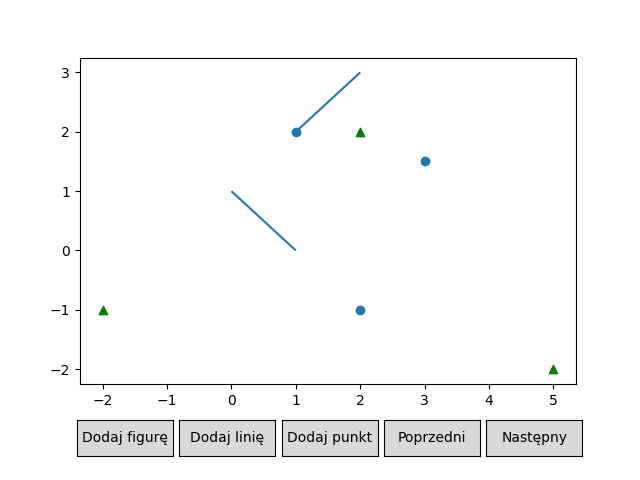

In [14]:
%matplotlib notebook

plot = Plot(points=[PointsCollection([(1, 2), (3, 1.5), (2, -1)]),
               PointsCollection([(5, -2), (2, 2), (-2, -1)], color='green', marker = "^")],
            lines=[LinesCollection([[(1,2),(2,3)], [(0,1),(1,0)]])])
plot.draw()

##### Rysunek dynamiczny

To narzędzie pozwala na wizualizację "rysunków dynamicznych", a więc takich, które składają się z wielu różnych obrazów. Może to być przydatne np. podczas wizualizacji kolejnych kroków danego algorytmu. Poszczególne klatki określane są jako obiekty `Scene`, które przyjmują listę `PointsCollection` oraz listę `LinesCollection` w swoim konstruktorze. Obiekt `Plot` przyjmuje w parametrze konstruktora `scenes` właśnie listę takich scen.

Na rysunku przyciski `Następny` i `Poprzedni` służą do nawigacji pomiędzy nimi.

<IPython.core.display.Javascript object>


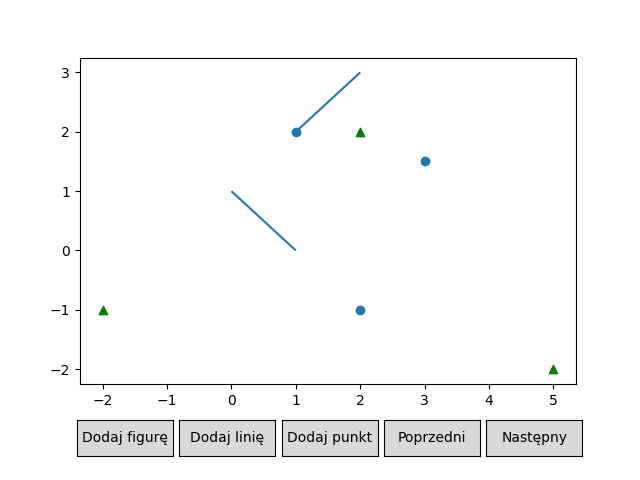

In [15]:
%matplotlib notebook

scenes=[Scene([PointsCollection([(1, 2), (3, 1.5), (2, -1)]), 
               PointsCollection([(5, -2), (2, 2), (-2, -1)], color='green', marker = "^")], 
              [LinesCollection([[(1,2),(2,3)], [(0,1),(1,0)]])]), 
        Scene([PointsCollection([(1, 2), (3, 1.5), (2, -1)], color='red'), 
               PointsCollection([(5, -2), (2, 2), (-2, 1)], color='black')], 
              [LinesCollection([[(-1,2),(-2,3)], [(0,-1),(-1,0)]])])]

plot=Plot(scenes = scenes)
plot.draw() 


###### Zapis i odczyt z pliku

Klasa Plot posiada metodę `toJson()`, która zwraca string zawierający listę scen w formacie JSON. Taki string można normalnie zapisać do pliku stosując normalne sposoby dostępne w Pythonie. Wczytanie listy scen z pliku dokonuje się poprzez podanie parametru `json` w kostruktorze `Plot`.

<IPython.core.display.Javascript object>


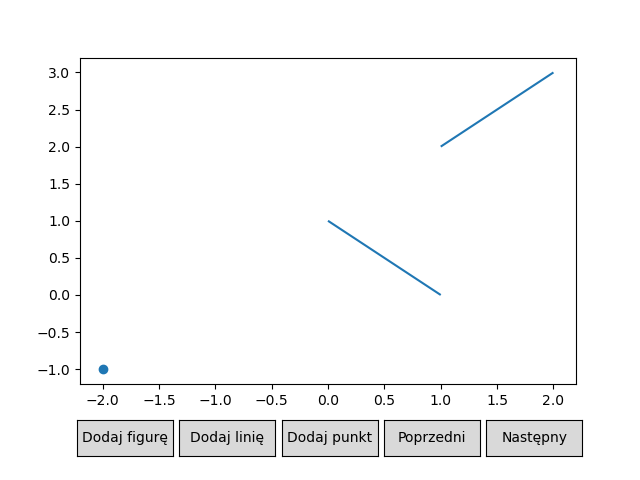

In [16]:
scenes=[Scene([PointsCollection([(-2, -1)], color='green', marker = "^")], 
              [LinesCollection([[(1,2),(2,3)], [(0,1),(1,0)]])]), 
        Scene([PointsCollection([(1, 2), (3, 1.5)], color='red'), 
               PointsCollection([(5, -2)], color='black')])]
plot = Plot(scenes)

with open('somefile.json', 'w') as file:
    file.write(plot.toJson())
    
#somefile.json: [{"points": [[[-2, -1]]], "lines": [[[[1, 2], [2, 3]], [[0, 1], [1, 0]]]]}, {"points": [[[1.0, 2.0], [3.0, 1.5]], [[5, -2]]], "lines": []}]
    
with open('somefile.json', 'r') as file:
    json = file.read()
    
plot2 = Plot(json=json)
plot2.draw()

##### Operowanie na dodanych punktach

Możemy bardzo łatwo rysować nowe punkty i linie. Aby je później wykorzystać sugerowanym sposobem jest utworzenie nowej komórki, w której utworzymy nowy `Plot` i skorzystamy z metod `get_added_points()` i `get_added_points()` lub `get_added_elements()` (zwraca scenę) z pierwszego `Plot`u.

<IPython.core.display.Javascript object>


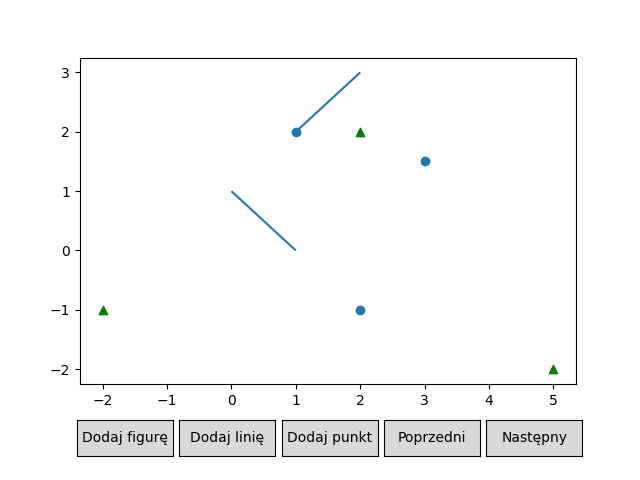

In [17]:
#Dodaj tu punkty, figury i/lub odcinki!
plot1 = Plot()
plot1.draw()

<IPython.core.display.Javascript object>


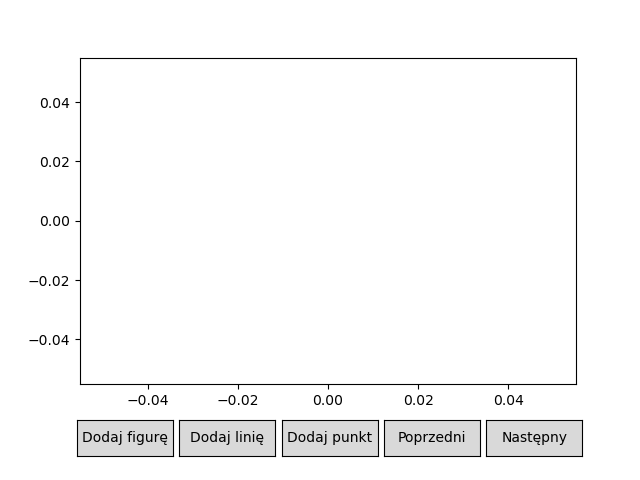

In [18]:
plot2 = Plot([plot1.get_added_elements()])
plot2.draw()

## Import LifoQueue (stosu) oraz metod Uniform oraz random (do generowania punktów)

In [19]:
from queue import LifoQueue, Queue    # import kolejki uzywanej w algorytmie Grahama
from random import uniform, randint   # import funkcji uniform and randint, uzywanych w generowaniu zbiorów
from copy import copy, deepcopy       # import metody deepcopy, potrzebnej do kopiowania zbiorów punktów 
from math import sqrt
from timeit import default_timer as timer

## Deklaracja wartości pomocniczych oraz funkcji do badania wzajemnego położenia wierzchołków

In [ ]:
INF = 1e5
EPS = 1e-10
# funkcja dist zwraca dystans między dwoma punktami w R^2
def dist(p1, p2):
    return sqrt(((p1[0] - p2[0])**2 + (p1[1] - p2[1])**2))

# funkcja orienta zwraca wyznacznik macierzy postaci
#  | ax, ay, 1 |
#  | bx, by, 1 |
#  | cx, cy, 1 |
# wyznacznik ten definiuje po jakiej stronie (lewo / prawo)
# znajduje się punkt c względem wektora -ab->
def orient(a, b, c):
    return a[0]*b[1] + a[1]*c[0] + b[0]*c[1] - b[1]*c[0] - a[1]*b[0] - a[0]*c[1]

# zwraca odległość między punktami p1 i p2 w metryce euklidesowej
def dist(p1, p2):
    return sqrt(((p1[0] - p2[0])**2 + (p1[1] - p2[1])**2))

# zwraca kąt między wektorami -ab-> i -bc-> zgodnie z wskazówkami zegara
def angle_cw(a, b, c):
    if c == a or c == b or a == b:
        return 0

    vec1 = [b[0] - a[0], b[1] - a[1]]
    vec2 = [c[0] - b[0], c[1] - b[1]]
    unit_vec1 = vec1 / np.linalg.norm(vec1)
    unit_vec2 = vec2 / np.linalg.norm(vec2)

    angle = np.arccos(np.dot(unit_vec1, unit_vec2))
    o = orient(a, b, c)

    if o < 0:
        angle = 2*np.pi - angle
    
    return angle

# zwraca kąt między osią OX a wektorem -ab-> wyznaczony przez łuk idący 
# odwrotnie do wskazówek zegara od OX do -ab->
def ox_angle(a, b):
    if a == b:
        return 0
    
    unit_vec1 = (1, 0)
    vec2 = (b[0] - a[0], b[1] - a[1])
    unit_vec2 = vec2 / np.linalg.norm(vec2)

    angle = np.arccos(np.dot(unit_vec1, unit_vec2))

    return angle

# Generowanie zbiorów

## Zestaw A

50000 500000


<IPython.core.display.Javascript object>


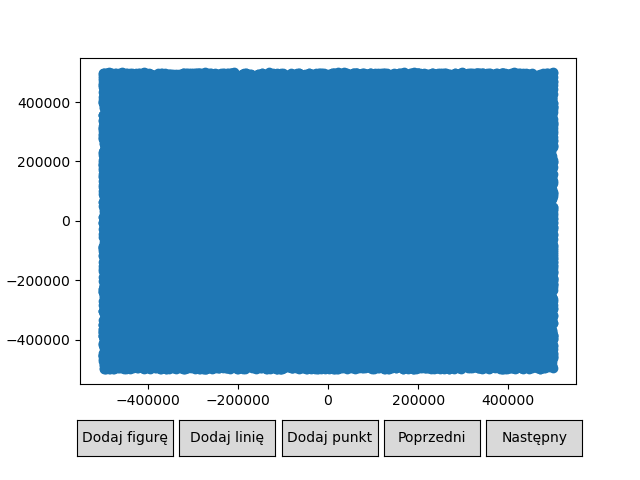

In [384]:
# Generowanie losowo punktów w przestrzeni 2D w zakresie [-LIM, LIM]
def generateA(n, LIM):
    A = []

    for _ in range(int(n)):
        x = uniform(-LIM, LIM)
        y = uniform(-LIM, LIM)

        A.append((x, y))
    
    return A

n, LIM = map(float, input().split())

A = generateA(n, LIM)
plot = Plot(points = [PointsCollection(A)])
plot.draw()

## Zestaw B

10000 10000


<IPython.core.display.Javascript object>


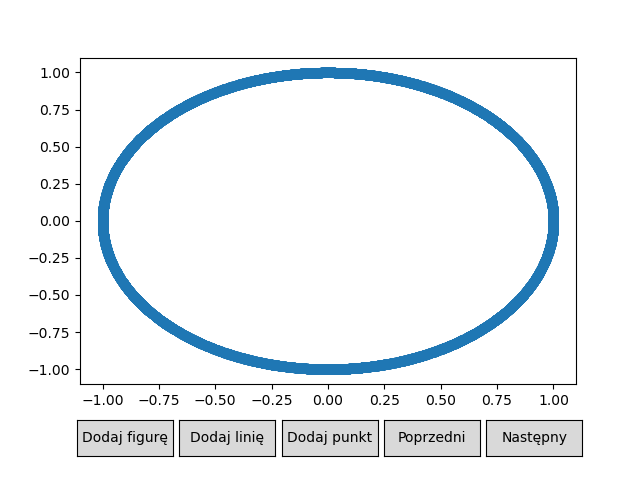

In [392]:
# Generowanie losowo punktów w przestrzeni 2D na okręgu o środku w punkcie (0,0)
def generateB(n, R):
    B = []

    for _ in range(int(n)):
        v = uniform(0, 2*np.pi)

        x = np.sin(v)
        y = np.cos(v)
        B.append((x, y))
    
    return B

n, R = map(float, input().split())
B = generateB(n, R)

plot = Plot(points = [PointsCollection(B)])
plot.draw()

## Zestaw C

50000 -50000 50000 -50000 50000


<IPython.core.display.Javascript object>


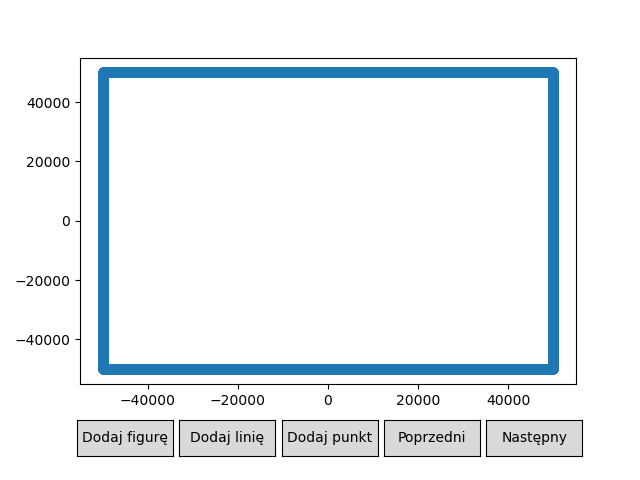

In [386]:
# Generowanie losowo punktów w przestrzeni 2D rozmieszczonych na bokach prostokąta, 
def generateC(n, xmin, xmax, ymin, ymax):
    C = []

    for _ in range(int(n)):
        side = randint(0, 4)
        if side == 0:
            C.append((uniform(xmin, xmax), ymin))
        elif side == 1:
            C.append((xmax, uniform(ymin, ymax)))
        elif side == 2:
            C.append((uniform(xmin, xmax), ymax))
        else:
            C.append((xmin, uniform(ymin, ymax)))

    return C

n, xmin, xmax, ymin, ymax = map(float, input().split())
C = generateC(n, xmin, xmax, ymin, ymax)

plot = Plot(points = [PointsCollection(C)])
plot.draw()

## Zestaw D

0 0 50000 12500 12500


<IPython.core.display.Javascript object>


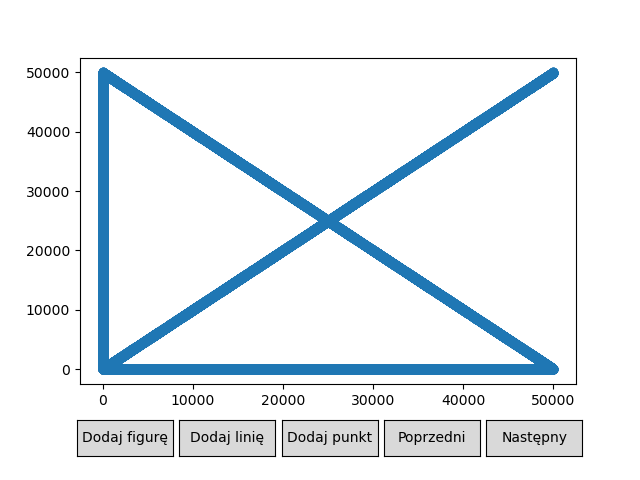

In [387]:
# Generowanie losowo punktów w przestrzeni 2D rozmieszczonych na dwóch bokach kwadratu 
# (pokrywających się z osiami X oraz Y) oraz na jego przekątnych
# Wierzchołki kwadratu również należą do zbioru punktów
def generateD(x, y, width, axis_points, diagonal_points):
    D = [(x, y), (x + width, y), (x, y + width), (x + width, y + width)]

    for i in range(int(axis_points)):
        D.append((x, y + uniform(0, width)))

    for i in range(int(axis_points)):
        D.append((x + uniform(0, width), y))

    for i in range(int(diagonal_points)):
        a = uniform(0, width)
        D.append((x+a, y+a))

    for i in range(int(diagonal_points)):
        a = uniform(0, width)
        D.append((x+a, y+width-a))

    return D


x, y, width, axis_points, diagonal_points = map(float, input().split())
D = generateD(x, y, width, axis_points, diagonal_points)
        
plot = Plot(points = [PointsCollection(D)])
plot.draw()

# Implementacja algorytmów Jarvisa i Grahama

## Implementacja algorytmu Jarvisa zwracającego kolejne etapy wyznaczania otoczki

In [361]:
def jarvis_with_scenes(S):
    # sortowanie punktów (stabilne) najpierw
    # po x, potem po y

    S = sorted(S, key = lambda x : x[0])
    S = sorted(S, key = lambda x : x[1])

    # p1 jest punktem o najmniejszej współrzędnej x wśród punktów
    # o najmniejszej współrzędnej y - ten punkt na pewno znajdzie się w otoczce
    p1 = S[0]
    prev = None
    current = p1
    scenes = [[[p1], []]]
    back_in_p1 = False
    A = [None]*len(S)
    
    # pętle wykonuję do momentu, aż powrócę do punktu p1
    while not back_in_p1:
        # jeśli prev (przedostatni punkt dodany do otoczki) nie istnieje (bo w otoczce mamy tylko p0)
        # obliczam kąt między każdym punktem a osią OX
        if prev is None:
            for i in range(len(A)):
                A[i] = [ox_angle(p1, S[i]), dist(S[i], current), i]
        # w.p.p obliczam kąt między wektorami -a-S[i]-> i -a-b-> gdzie a i b to 
        # odpowiednio ostatni i przedostatni punkt dodany do otoczki
        else:
            for i in range(len(A)):
                A[i] = [angle_cw(prev, current, S[i]), dist(current, S[i]), i]
        
        A = sorted(A, key= lambda x: x[1], reverse= True)
        A = sorted(A, key= lambda x: x[0], reverse= True)


        prev = current
        current = S[A[0][2]]
        new_scene = deepcopy(scenes[len(scenes) - 1])


        if p1 != current:
            new_scene[0].append(current)
        else:
            back_in_p1 = True

        new_scene[1].append([prev, current])
        scenes.append(new_scene)
    
    return scenes

## Generowanie wykresu dla algorytmu Jarvisu

In [369]:
def generate_plot_jarvis(P):
    tmp = deepcopy(P)

    scenes = jarvis_with_scenes(tmp)
    
    m = len(scenes)
    last_points = scenes[m-1][0]
    
    
    for i in range(m-1):
        scenes[i] = Scene([PointsCollection(P),
                           PointsCollection(scenes[i][0], color = 'red'),
                           PointsCollection(scenes[i][0][:-1], color = 'blue'),], 
                          [LinesCollection(scenes[i][1], color = 'red')])
        
    scenes[m-1] = Scene([PointsCollection(P, color = 'blue'), PointsCollection(last_points, color = 'red')],
                      [LinesCollection(scenes[m-1][1], color = 'red')])
    
    return Plot(scenes)

## Otoczka wypukła zbioru A (Algorytm Jarvisa)

<IPython.core.display.Javascript object>


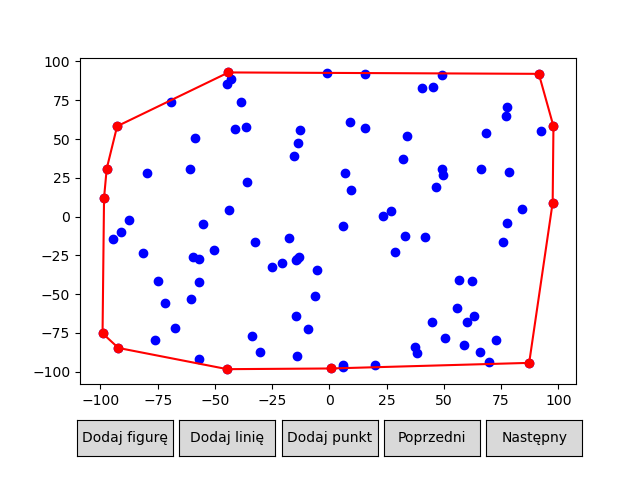

In [370]:
plot = generate_plot_jarvis(copy(A))
plot.draw()

## Otoczka wypukła zbioru B (Algorytm Jarvisa)

In [ ]:
plot = generate_plot_jarvis(copy(B))
plot.draw()

## Otoczka wypukła zbioru C (Algorytm Jarvisa)

<IPython.core.display.Javascript object>


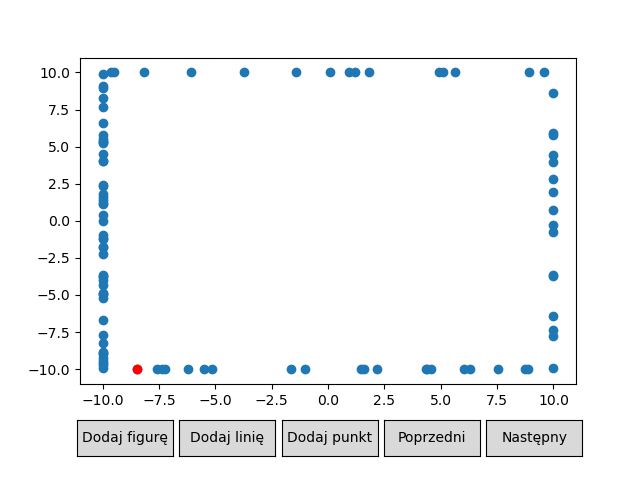

In [244]:
plot = generate_plot_jarvis(copy(C))
plot.draw()

## Otoczka wypukła zbioru D (Algorytm Jarvisa)

<IPython.core.display.Javascript object>


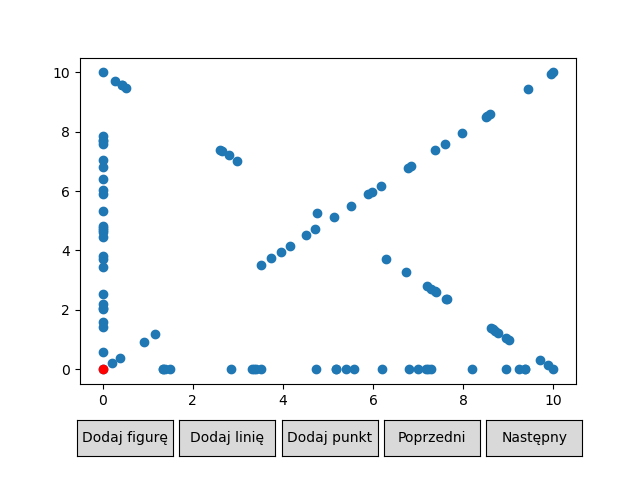

In [245]:
plot = generate_plot_jarvis(copy(D))
plot.draw()

## Implementacja algorytmu Grahama zwracającego kolejne etapy wyznaczania otoczki

In [ ]:
# scenes[i] - i-ty etap wyznaczania otoczki
# dropped[i] - punkty odrzucone z potencjalnej otoczki do kroku i (włącznie)

def graham_with_scenes(S):
    # usuwam ze zbioru punkt o najmniejszym y (jesli jest ich kilka to ten wsrod nich o najmniejszym x)
    # ten punkt na pewno znajdzie sie w otoczce 
    p0 = min(S, key = lambda x : (x[1], x[0]))
    S.remove(p0)
    
    # kazde pole w liscie A bedzie zawierac informacje
    # [a, b, c]
    # a - indeks punktu z tablicy S, do ktorego to pole w tablicy A sie odnosi
    # b - ogleglosc w metryce euklidesowej miedzy punktem p0 a S[a]
    # c - kat miedzy wektorem rownoleglym z osia OX i wektorem -p0-S[a]->
    A = []

    for i in range(len(A)):
        A.append([i, dist(p0, S[i]), ox_angle(p0, S[i])])
    
    # sortuje tablice A najpierw po wartosciach b malejąco
    # nastepnie po wartosciach c rosnaco
    A = sorted(A, key = lambda v : v[2])
    
    # lista dropped zawiera punkty wyznaczone jako nienależące do otoczki w każdym z kroków
    dropped = [[]]
    
    # eliminuje wszystkie punkty o tej samej wartosci c za wyjatkiem
    # najbardziej oddalonego od p0 i dodaje do dropped[0]
    i = 0
    while i < len(A)-1:
        if abs(A[i][2] - A[i+1][2]) < EPS:
            if A[i][1] < A[i+1][1]:
                dropped[0].append(S[A.pop(i)[0]])
            else:
                dropped[0].append(S[A.pop(i+1)[0]])
        else:
            i += 1

    p1 = S[A[0][0]]
    p2 = S[A[1][0]]
    scenes = [[[p0, p1], [p1, p2]]]
    
    for i in range(2, len(A)):
        dropped.append(copy(dropped[-1]))
        new_point = S[A[i][0]]
        new_scene = deepcopy(scenes[len(scenes)-1])

        a, b = new_scene[len(new_scene)-1]
        while len(new_scene) > 1 and orient(a, b, new_point) < EPS:
            dropped[i-1].append(new_scene.pop()[1])
            a, b = new_scene[len(new_scene)-1]

        new_scene.append([b, new_point])
        scenes.append(new_scene)
    
    last_scene = deepcopy(scenes[len(scenes)-1])
    last_scene.append([new_point, p0])
    scenes.append(last_scene)

    return scenes, dropped

## Generowanie wykresu dla algorytmu Grahama

In [371]:
def generate_plot_graham(P):
    
    scenes, dropped = graham_with_scenes(copy(P))
    
    m = len(scenes)
    last = scenes[m-1]
    
    for i in range(m-1):
        scenes[i] = Scene([PointsCollection(P, color = 'blue'), 
                           PointsCollection(dropped[i], color = 'cyan'),
                          PointsCollection(scenes[i][-1], color = 'red')],
                          [LinesCollection(scenes[i][:-2], color = 'green'),
                          LinesCollection(scenes[i][-2:], color = 'red')])
    
    points = []
    for edge in last:
        points.append(edge[0])
    
    scenes[m-1] = Scene([PointsCollection(P, color = 'blue'), 
                         PointsCollection(points, color = 'red')], 
                        [LinesCollection(last, color = 'red')])
    
    
    return Plot(scenes)

## Otoczka wypukła zbioru A (Algorytm Grahama)

<IPython.core.display.Javascript object>


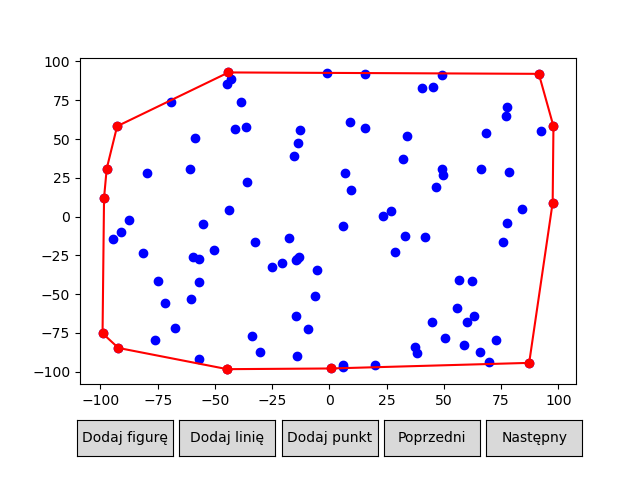

In [372]:
plot = generate_plot_graham(copy(A))
plot.draw()

## Otoczka wypukła zbioru B (Algorytm Grahama)

<IPython.core.display.Javascript object>


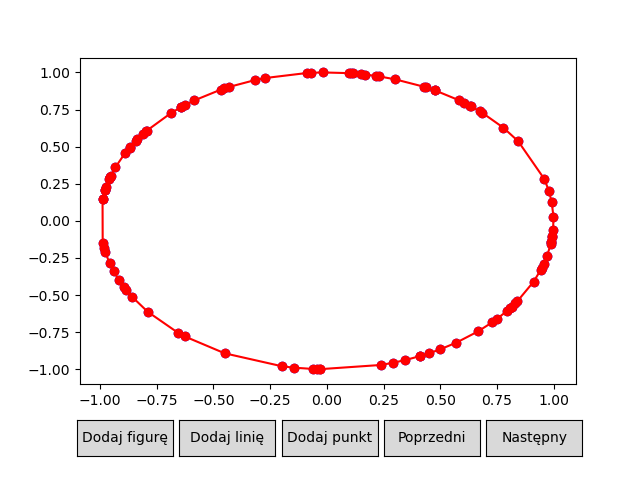

In [373]:
plot = generate_plot_graham(copy(B))
plot.draw()

## Otoczka wypukła zbioru C (Algorytm Grahama)

<IPython.core.display.Javascript object>


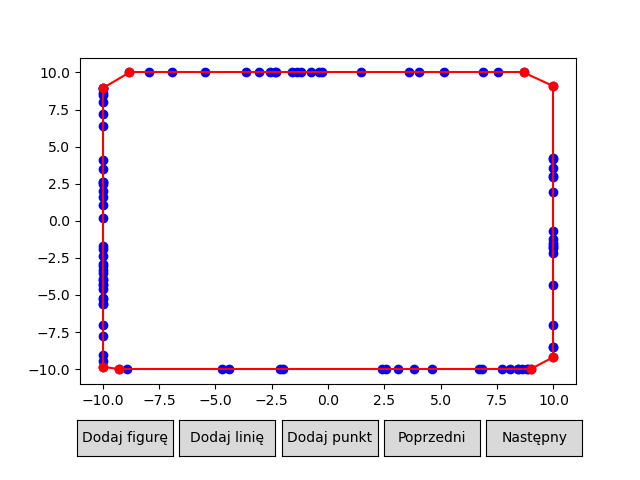

In [374]:
plot = generate_plot_graham(copy(C))
plot.draw()

## Otoczka wypukła zbioru D (Algorytm Grahama)

<IPython.core.display.Javascript object>


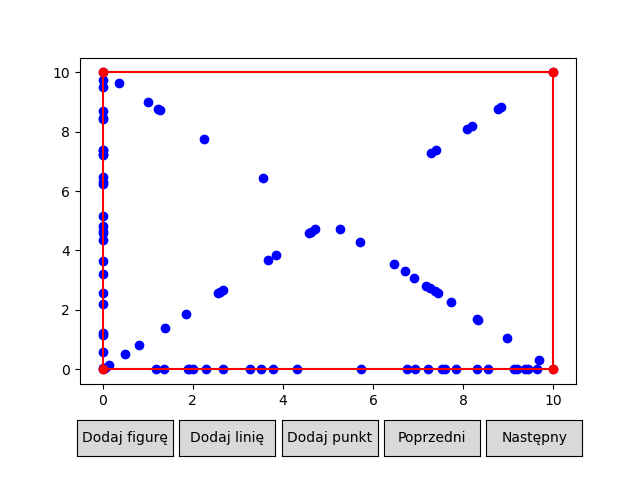

In [375]:
plot = generate_plot_graham(copy(D))
plot.draw()

# Implementacje algorytmów Grahama oraz Jarvisa (brak zwracania ścieżki)

In [302]:
def graham(S):
    S = sorted(S, key = lambda v : v[0])
    S = sorted(S, key = lambda v : v[1])

    p0 = S.pop(0)

    A = [None]*len(S)

    for i in range(len(A)):
        angle = ox_angle(p0, S[i])
        A[i] = [i, dist(p0, S[i]), angle]
    
    A = sorted(A, key = lambda v : v[1], reverse = True)
    A = sorted(A, key = lambda v : v[2])

    while i < len(A)-1:
        if abs(A[i][2] - A[i+1][2]) < EPS:
            if A[i][1] < A[i+1][1]:
                A.pop(i)
            else:
                A.pop(i+1)
    
    stack = Queue()

    stack.put(p0)
    stack.put(S[A[0][0]])
    stack.put(S[A[1][0]])

    for i in range(2, len(A)):
        b = stack.get()
        a = stack.get()
        c = S[A[i][0]]

        while stack.qsize() > 1 and orient(a, b, c) < EPS:
            a, b = stack.get(), a
        
        stack.put(a)
        stack.put(b)
        stack.put(c)
    
    return stack

In [309]:
def jarvis(S):
    # sortowanie punktów (stabilne) po x -> po y
    S = sorted(S, key= lambda x : x[0])
    S = sorted(S, key= lambda x : x[1])

    p1 = S[0]
    convex_hull = [p1]
    
    current = p1
    prev = None
    back_in_p1 = False
    A = [None]*len(S)

    while not back_in_p1:
        if prev is None:
            for i in range(len(A)):
                A[i] = [ox_angle(p1, S[i]), dist(p1, S[i]), i]
        else:
            for i in range(len(A)):
                A[i] = [angle_cw(prev, current, S[i]), dist(current, S[i]), i]
        
        A = sorted(A, key= lambda x: x[1], reverse= True)
        A = sorted(A, key= lambda x: x[0], reverse= True)

        prev = current
        current = S[A[0][2]]

        if p1 == current:
            back_in_p1 = True
        
        convex_hull.append(current)
    
    return convex_hull

# Porównanie czasu wyznaczania otoczki dla różnych zbiorów

In [319]:
def compare_time(s, set_name):
    print("Porównanie czasu wyznaczenia otoczki dla zbioru: " + set_name)
    
    s1 = copy(s)
    s2 = copy(s)
    
    start_g = timer()
    graham(s1)
    end_g = timer()
    
    graham_time = end_g - start_g
    print("Algorytm Grahama: {:.6f} s".format(graham_time))
    
    start_j = timer()
    jarvis(s2)
    end_j = timer()
    
    jarvis_time = end_j - start_j
    
    print("Algorytm Jarvisa: {:.6f} s".format(jarvis_time))
    print('---------------------------------------------------')

In [388]:
compare_time(A, "A")

Porównanie czasu wyznaczenia otoczki dla zbioru: A
Algorytm Grahama: 1.068468 s
Algorytm Jarvisa: 22.060215 s
---------------------------------------------------


In [391]:
compare_time(B, "B")

Porównanie czasu wyznaczenia otoczki dla zbioru: B
Algorytm Grahama: 1.179737 s


KeyboardInterrupt: 

In [389]:
compare_time(C, "C")

Porównanie czasu wyznaczenia otoczki dla zbioru: C
Algorytm Grahama: 1.009689 s
Algorytm Jarvisa: 6.243919 s
---------------------------------------------------


In [390]:
compare_time(D, "D")

Porównanie czasu wyznaczenia otoczki dla zbioru: D
Algorytm Grahama: 1.027977 s
Algorytm Jarvisa: 2.945436 s
---------------------------------------------------
